**IMPORTING ALL DEPENDENCIES**> 

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.model_selection import train_test_split
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model, Wav2Vec2FeatureExtractor, Wav2Vec2Tokenizer, Trainer, TrainingArguments, Wav2Vec2ForSequenceClassification,Wav2Vec2Processor
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install transformers --upgrade


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


****Loading Datasets****

In [3]:
import os

# List to store file paths
paths = []
labels = []

for dirname, _, filenames in os.walk(r'Datasets\audio_dataset\TESS Toronto emotional speech set data'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split("_")[-1]
        label = label.split(".")[0]
        labels.append(label.lower())


    if len(paths) == 2800:
        break


print(f"Total files: {len(paths)}")
print("Dataset is Loaded")


Total files: 2800
Dataset is Loaded


In [4]:
len(paths)

2800

In [5]:
paths[:10]

['Datasets\\audio_dataset\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_back_angry.wav',
 'Datasets\\audio_dataset\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bar_angry.wav',
 'Datasets\\audio_dataset\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_base_angry.wav',
 'Datasets\\audio_dataset\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bath_angry.wav',
 'Datasets\\audio_dataset\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bean_angry.wav',
 'Datasets\\audio_dataset\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_beg_angry.wav',
 'Datasets\\audio_dataset\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bite_angry.wav',
 'Datasets\\audio_dataset\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_boat_angry.wav',
 'Datasets\\audio_dataset\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_bone_angry.wav',
 'Datasets\\audio_dataset\\TESS Toronto emotional speech set data\\OAF_angry\\OAF_book_angry.wav']

In [6]:
df=pd.DataFrame()
df['audio_path']=paths
df['labels'] = labels

In [7]:
df

,audio_path,labels
0,Datasets\audio_dataset\TESS Toronto emotional ...,angry
1,Datasets\audio_dataset\TESS Toronto emotional ...,angry
2,Datasets\audio_dataset\TESS Toronto emotional ...,angry
3,Datasets\audio_dataset\TESS Toronto emotional ...,angry
4,Datasets\audio_dataset\TESS Toronto emotional ...,angry
...,...,...
2795,Datasets\audio_dataset\TESS Toronto emotional ...,sad
2796,Datasets\audio_dataset\TESS Toronto emotional ...,sad
2797,Datasets\audio_dataset\TESS Toronto emotional ...,sad
2798,Datasets\audio_dataset\TESS Toronto emotional ...,sad


In [8]:
df['labels'].value_counts()

labels
angry      400
disgust    400
fear       400
happy      400
neutral    400
ps         400
sad        400
Name: count, dtype: int64

**EDA (EXPLORATORY DATA ANALYSIS****)**

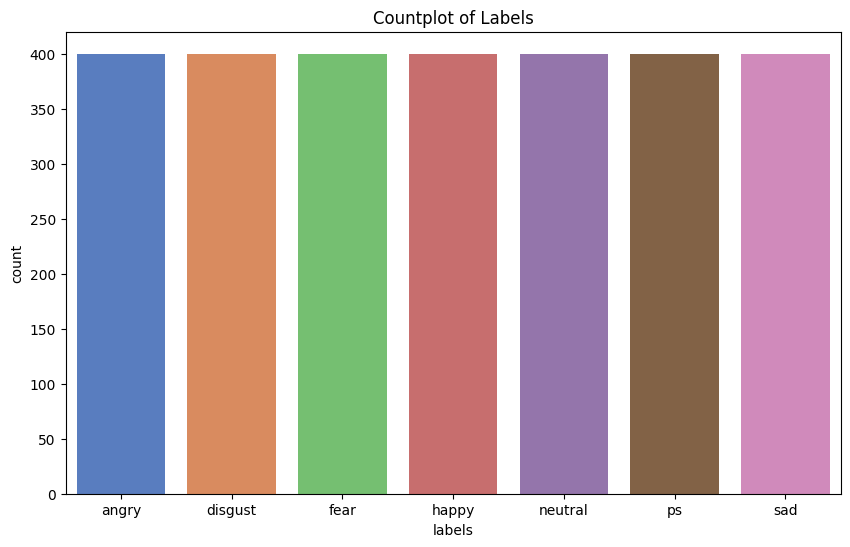

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="labels", palette="muted")
plt.title("Countplot of Labels")
plt.show()

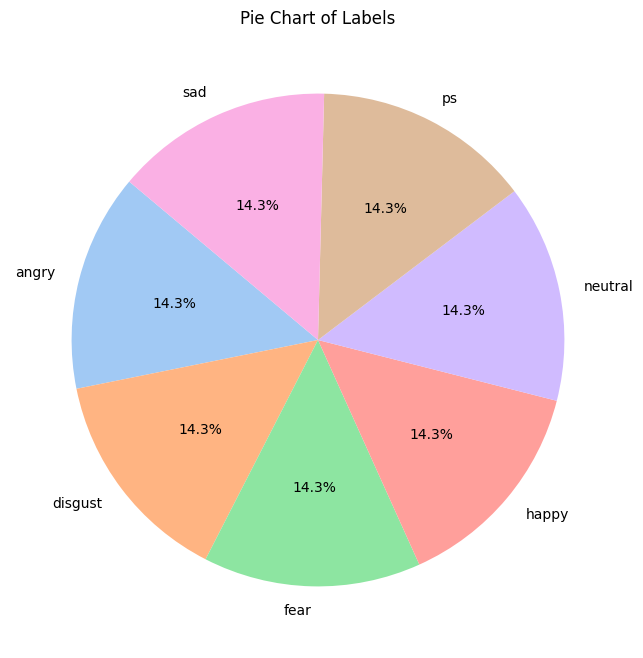

In [10]:
label_counts = df["labels"].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title("Pie Chart of Labels")
plt.show()

Processing: angry - Datasets\audio_dataset\TESS Toronto emotional speech set data\OAF_angry\OAF_back_angry.wav


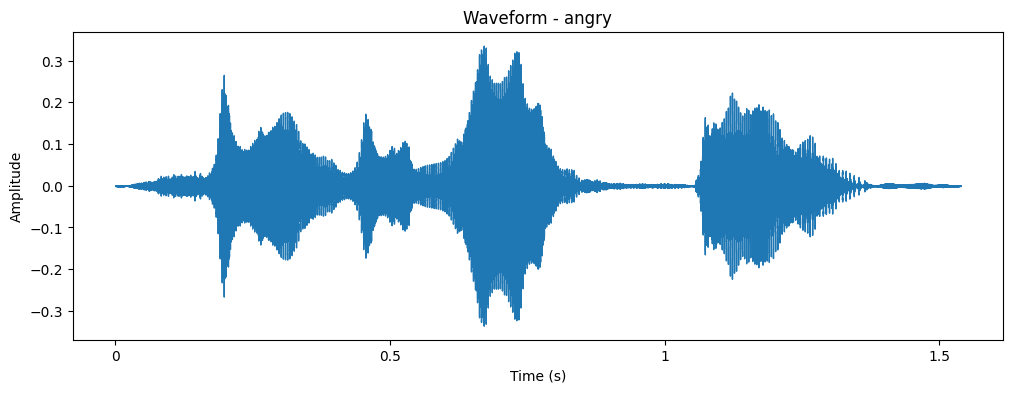

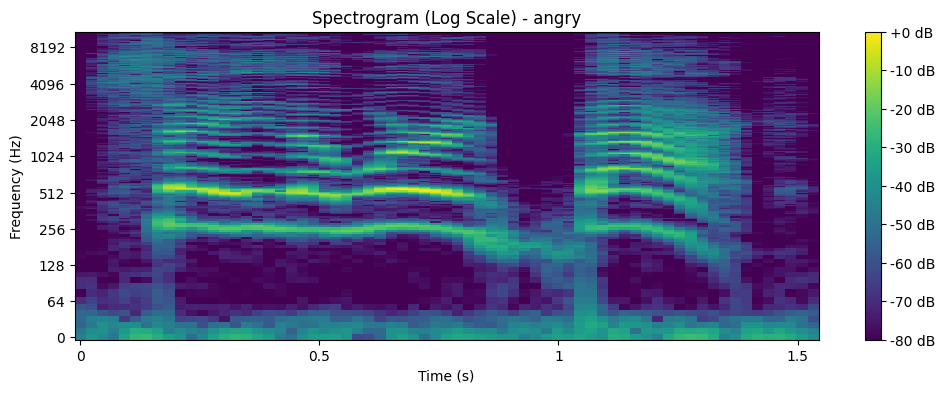

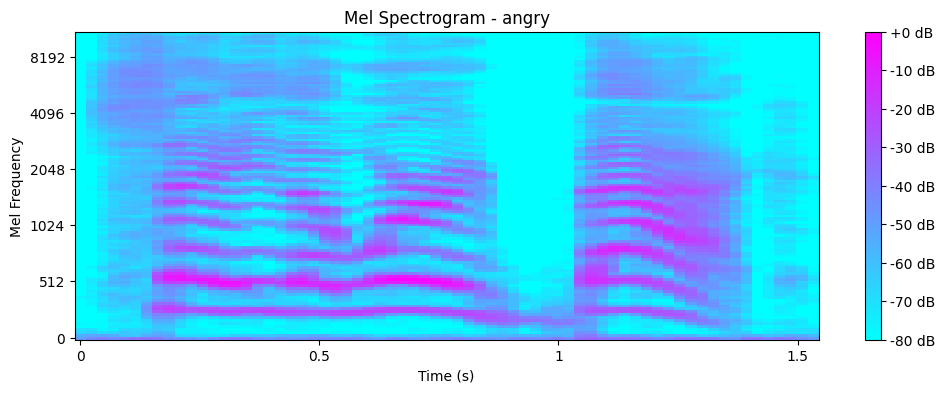

Processing: disgust - Datasets\audio_dataset\TESS Toronto emotional speech set data\OAF_disgust\OAF_back_disgust.wav


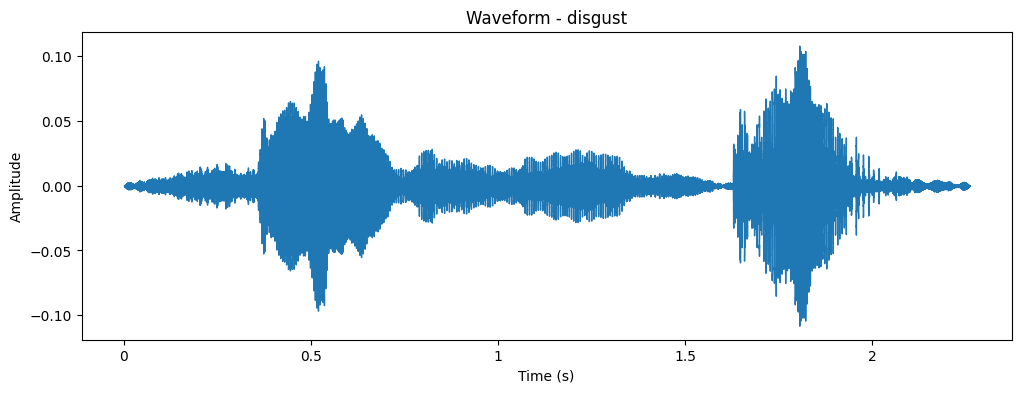

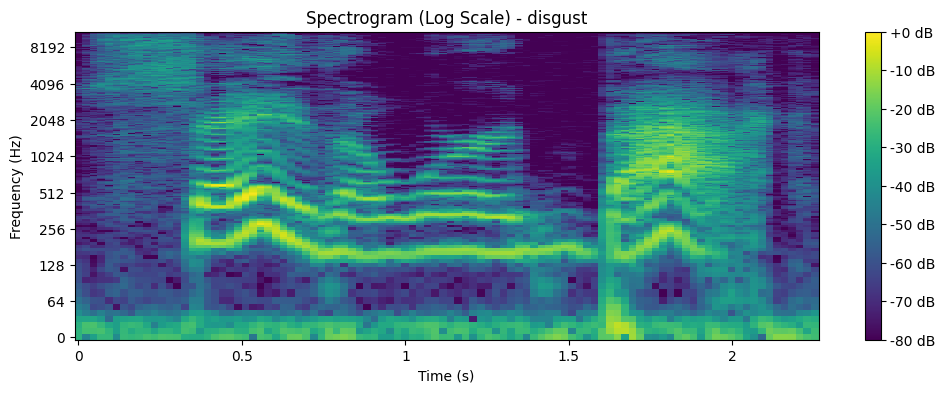

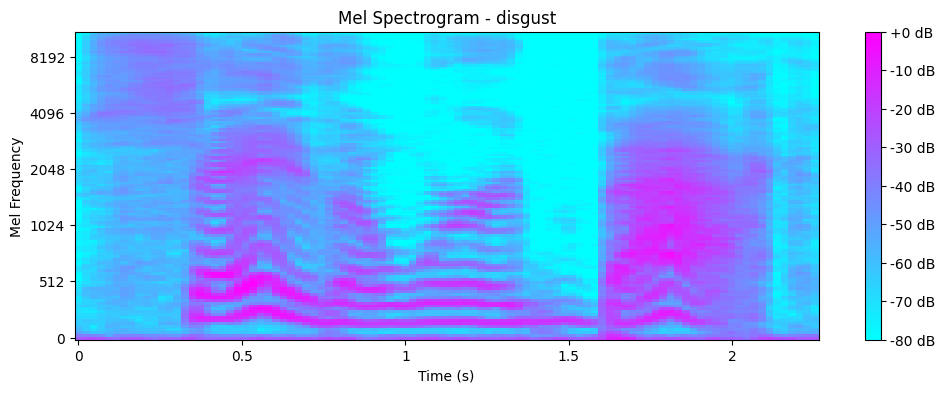

Processing: fear - Datasets\audio_dataset\TESS Toronto emotional speech set data\OAF_Fear\OAF_back_fear.wav


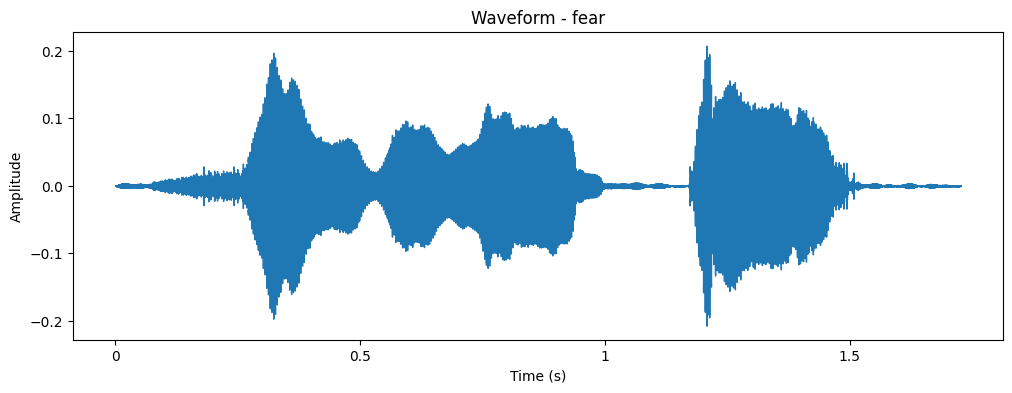

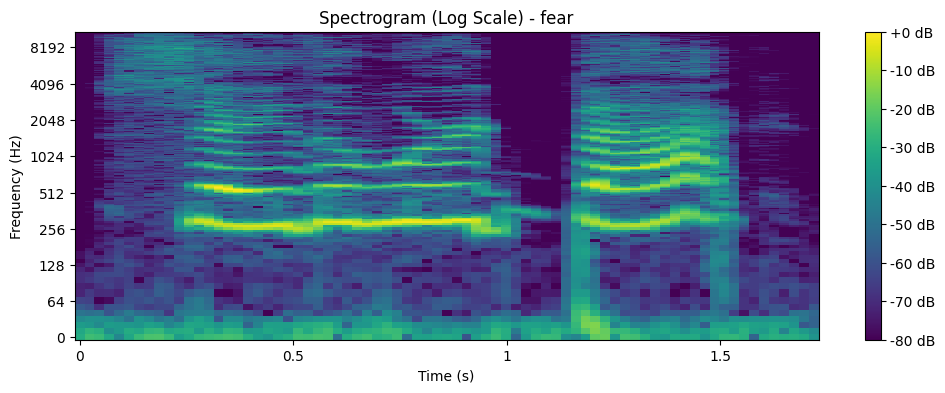

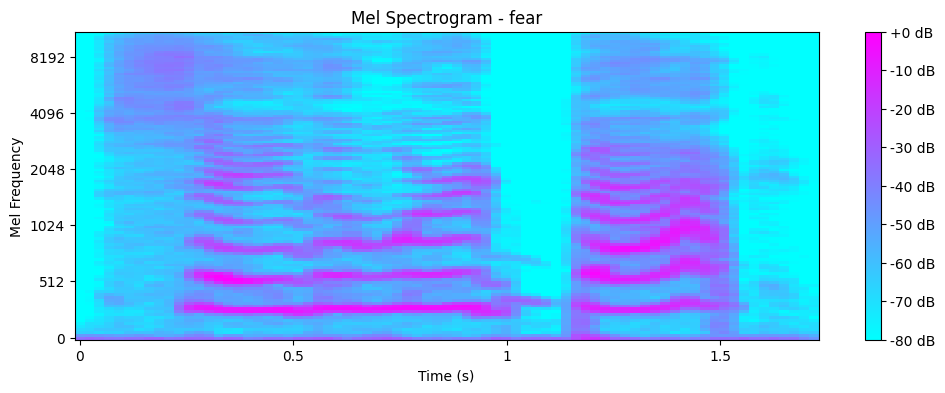

Processing: happy - Datasets\audio_dataset\TESS Toronto emotional speech set data\OAF_happy\OAF_back_happy.wav


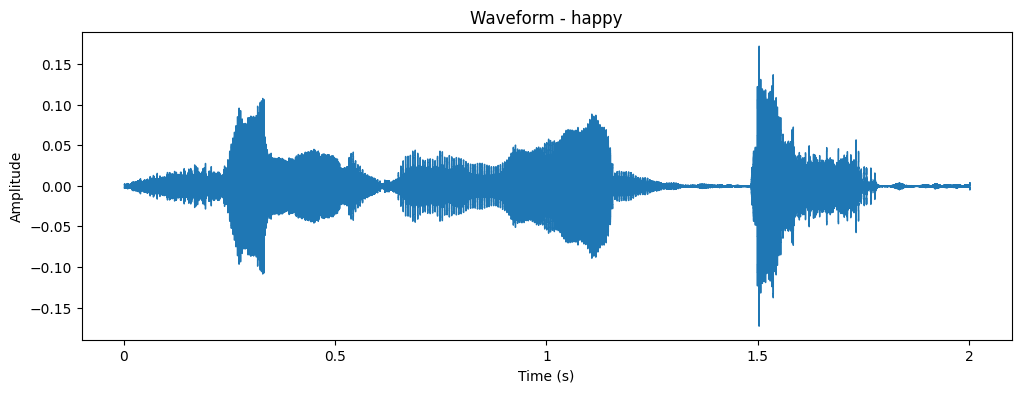

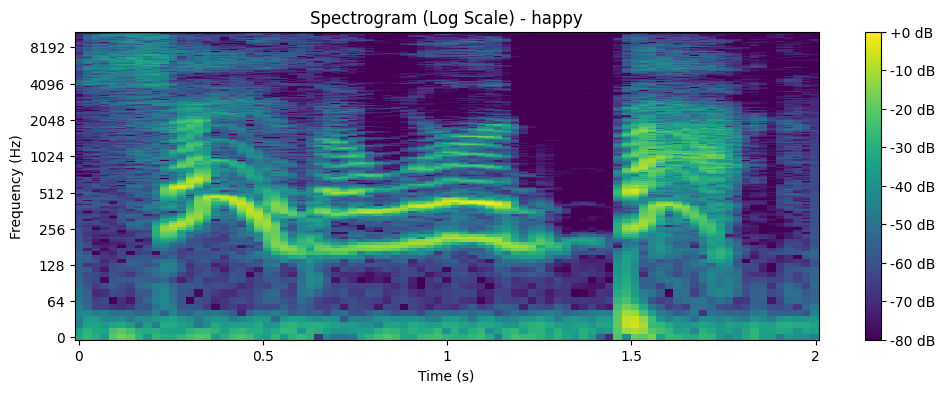

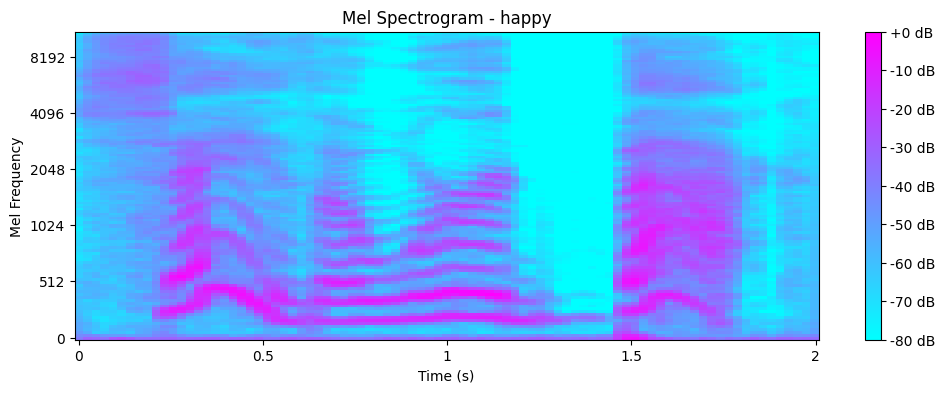

Processing: neutral - Datasets\audio_dataset\TESS Toronto emotional speech set data\OAF_neutral\OAF_back_neutral.wav


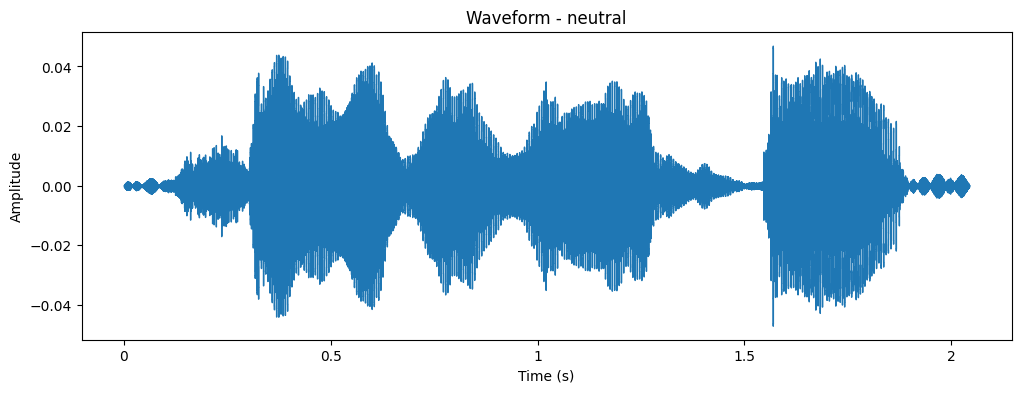

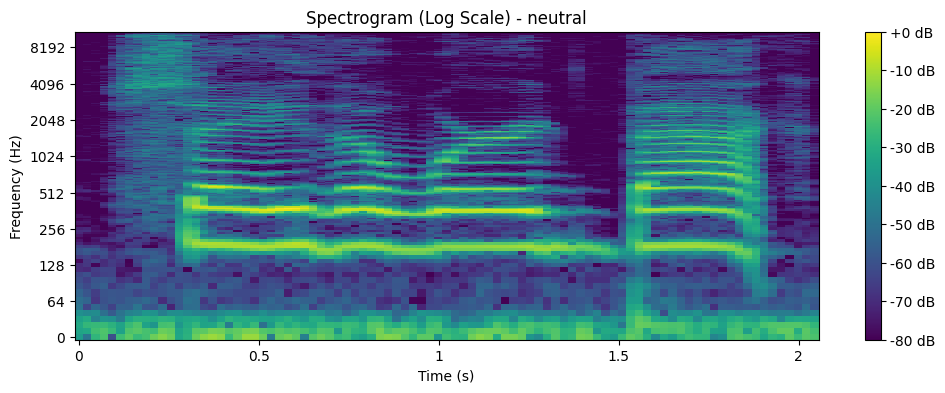

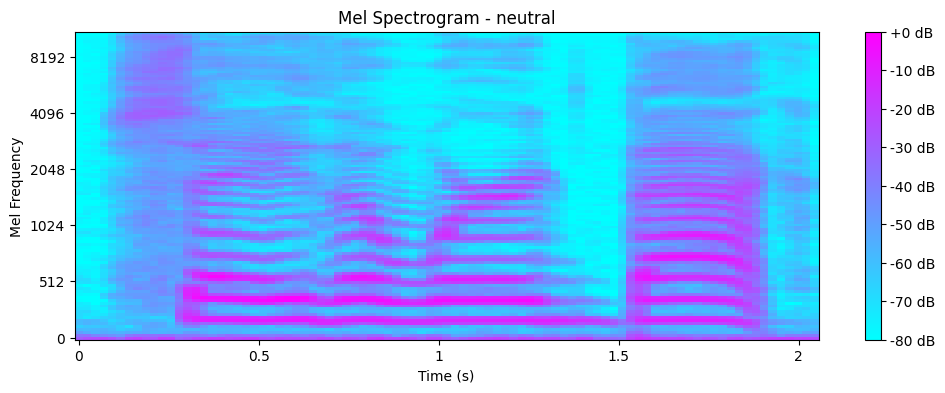

Processing: ps - Datasets\audio_dataset\TESS Toronto emotional speech set data\OAF_Pleasant_surprise\OAF_back_ps.wav


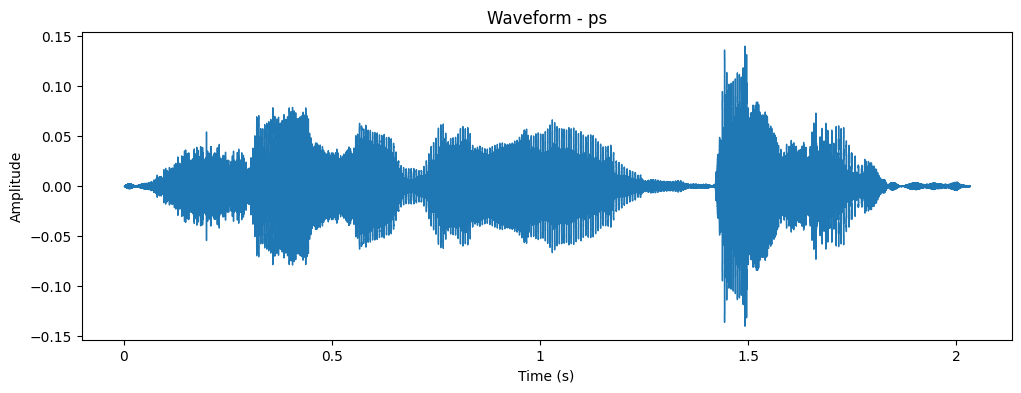

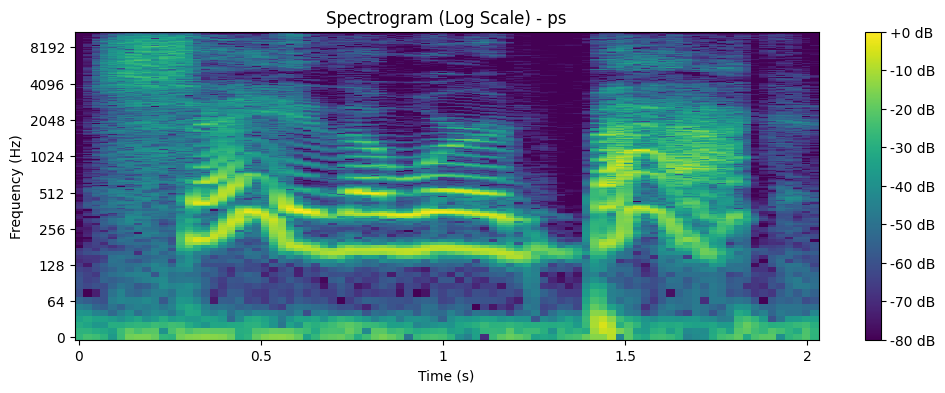

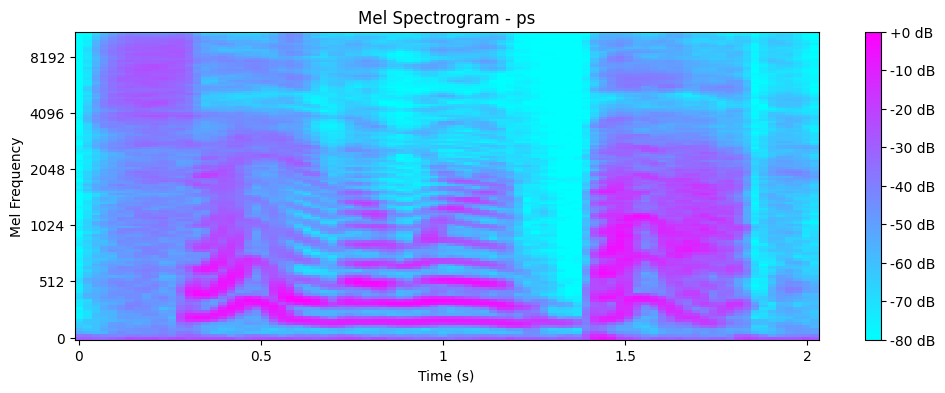

Processing: sad - Datasets\audio_dataset\TESS Toronto emotional speech set data\OAF_Sad\OAF_back_sad.wav


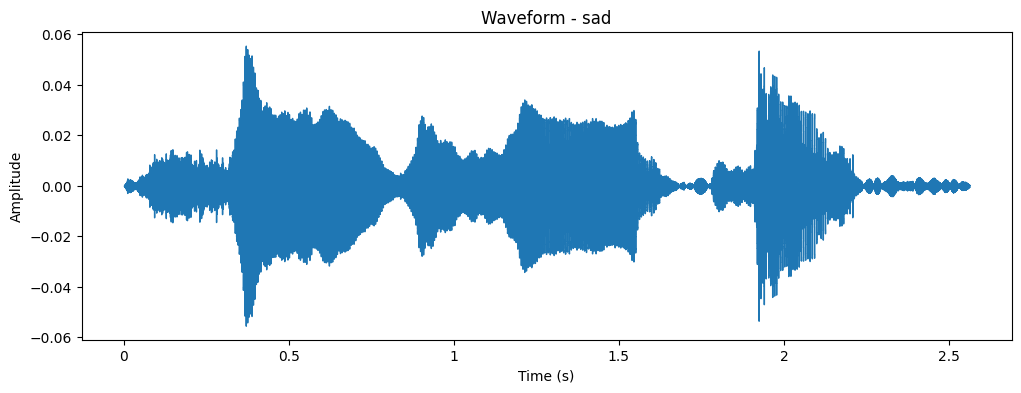

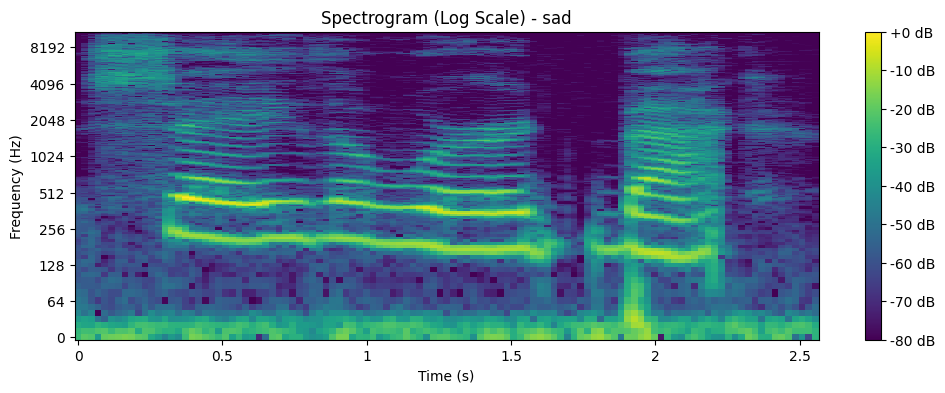

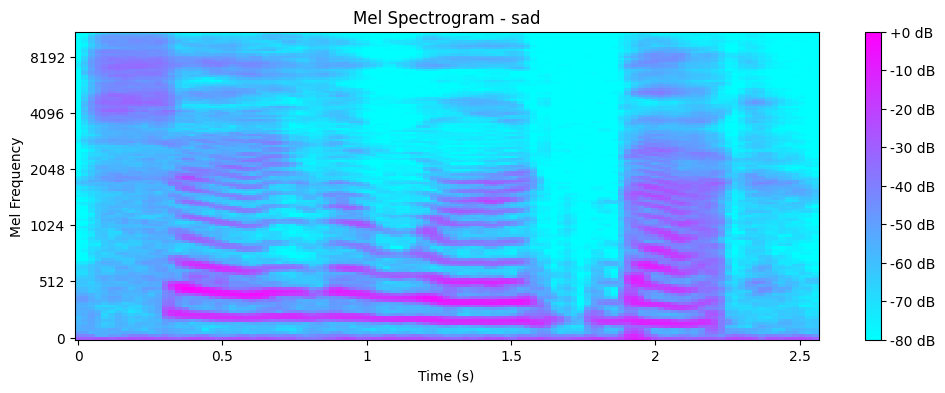

In [11]:


# Function to visualize audio features
def plot_audio_features(audio_path, label, sr=22050):
    y, sr = librosa.load(audio_path, sr=sr)
    
    # Plot Waveform
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform - {label}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

    # Plot Spectrogram
    plt.figure(figsize=(12, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', cmap='viridis')
    plt.title(f"Spectrogram (Log Scale) - {label}")
    plt.colorbar(format="%+2.0f dB")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.show()

    # Plot Mel Spectrogram
    plt.figure(figsize=(12, 4))
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', cmap='cool')
    plt.title(f"Mel Spectrogram - {label}")
    plt.colorbar(format="%+2.0f dB")
    plt.xlabel("Time (s)")
    plt.ylabel("Mel Frequency")
    plt.show()

# Select one file per category
unique_categories = df.groupby("labels").first().reset_index()

# Plot for each category
for _, row in unique_categories.iterrows():
    audio_path = row["audio_path"]
    label = row["labels"]
    print(f"Processing: {label} - {audio_path}")
    if os.path.exists(audio_path):
        plot_audio_features(audio_path, label)
    else:
        print(f"File not found: {audio_path}")


**CREATING CUSTOM LABELS TO INTEGERS FOR PROCESSING**

In [12]:
df['labels_int'] = pd.factorize(df['labels'])[0]

# Check the result
print(df.head())


                                          audio_path labels  labels_int
0  Datasets\audio_dataset\TESS Toronto emotional ...  angry           0
1  Datasets\audio_dataset\TESS Toronto emotional ...  angry           0
2  Datasets\audio_dataset\TESS Toronto emotional ...  angry           0
3  Datasets\audio_dataset\TESS Toronto emotional ...  angry           0
4  Datasets\audio_dataset\TESS Toronto emotional ...  angry           0


In [13]:
df['labels'].unique() # yelai chai unique integer ma convert gareko.

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad'],
      dtype=object)

In [14]:
df['labels_int'].unique() # sabai categorical lai numerical ma convert gareko

array([0, 1, 2, 3, 4, 5, 6])

**CREATING DATASET CLASS**

In [18]:
class SpeechEmotionData:
    
    def __init__(self, df, processor, max_length=32000):
        """
        Initialize the SpeechEmotionData class.

        Parameters:
        df (DataFrame): A pandas DataFrame containing the file paths to the audio files and their labels.
        processor: The processor or feature extractor used to transform the audio data into a suitable format for the model.
        max_length (int): The maximum length for each audio sample after padding or truncating. Default is 32000.
        """
        
        self.df = df
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['audio_path']
        label = self.df.iloc[idx]['labels_int']

        speech,sample_rate= librosa.load(audio_path,sr=16000)
      

        # Pad or truncate the speech to the maximum length
        if speech.shape[0] > self.max_length:
            speech = speech[:self.max_length]
        else:
            speech = np.pad(speech, (0, self.max_length - speech.shape[0]), 'constant')

        # Process audio for the model
        inputs = self.processor(speech, sampling_rate=16000, return_tensors='pt',
                                padding=True, truncation=True, max_length=self.max_length)

        # Extract input values
        input_values = inputs.input_values.squeeze()

        # Return the processed features and label
        return {'input_values': input_values, 'labels': torch.tensor(label, dtype=torch.long)}

**SPLITTING DATA INTO TRAINING AND TESTING SAMPLES**

In [16]:
train_data,test_data=train_test_split(df,test_size=0.2,random_state=42)

In [ ]:
processor=Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=7)

In [22]:
train_dataset = SpeechEmotionData(train_data,processor)
test_dataset = SpeechEmotionData(test_data,processor)

In [23]:
train_dataset[0]['input_values'].size()

torch.Size([32000])

In [24]:
print(train_data.columns)

Index(['audio_path', 'labels', 'labels_int'], dtype='object')


In [25]:
# Define DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

**SET TRAINING ARGUMENTS**

In [32]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    report_to="none"
)

In [33]:
# !pip install evaluate

In [34]:
import evaluate

# Load metrics
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

In [31]:
def compute_metrics(pred):
    """
    Compute precision, recall, F1-score, and accuracy for the predictions.

    Parameters:
    pred (PredictionOutput): Contains the logits and true labels.

    Returns:
    dict: Dictionary containing the computed metrics.
    """
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)
    
    # Compute individual metrics
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)['accuracy']
    precision = precision_metric.compute(predictions=predictions, references=labels, average='weighted')['precision']
    recall = recall_metric.compute(predictions=predictions, references=labels, average='weighted')['recall']
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')['f1']
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [35]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=processor,
    compute_metrics=compute_metrics
)



In [36]:
# Train and evaluate
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.610215,0.996429,0.996470,0.996429,0.996426
2,No log,0.358018,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=280, training_loss=0.9089750017438616, metrics={'train_runtime': 151.1108, 'train_samples_per_second': 29.647, 'train_steps_per_second': 1.853, 'total_flos': 8.134565376e+16, 'train_loss': 0.9089750017438616, 'epoch': 2.0})

**EVALUATIONS**

In [37]:
results=trainer.evaluate()
print(results)

{'eval_loss': 0.35801753401756287, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 4.8771, 'eval_samples_per_second': 114.822, 'eval_steps_per_second': 7.176, 'epoch': 2.0}


In [38]:
# Save model
trainer.save_model("speech_emotion_model")
processor.save_pretrained("speech_emotion_model")

[]

In [55]:
# !zip -r kaggle_working.zip /kaggle/working/

In [56]:
# from IPython.display import FileLink

# # Create a download link for the .zip file
# FileLink("/kaggle/working/speech_emotion_model.zip")

In [40]:
import random

inverse_label_map = {
    0: "fear",
    1: "angry",
    2: "disgust",
    3: "neutral",
    4: "sad",
    5: "ps",   
    6: "happy"
}

# Randomly select an index from the test dataset
idx = random.randrange(0, len(test_dataset))

# Print the original label
original_label = inverse_label_map[int(test_dataset[idx]['labels'])]
print("Original Label:", original_label)

# Get the input features and move them to the GPU if necessary
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')

# Perform inference without gradient computation
with torch.no_grad():
    outputs = model(input_values)
    logits = outputs.logits

# Get the predicted class
predicted_class = logits.argmax(dim=-1).item()

# Print the predicted label
predicted_label = inverse_label_map[predicted_class]
print('Predicted Label:', predicted_label)


Original Label: fear
Predicted Label: fear


**OWN CUSTOM AUDIO FILE TESTING **

In [ ]:
# import librosa
# import torch
# from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor

# # Load the model and processor from the same directory where your model is saved
# model = Wav2Vec2ForSequenceClassification.from_pretrained("/kaggle/working/speech_emotion_model")
# processor = Wav2Vec2Processor.from_pretrained("/kaggle/working/speech_emotion_model")

# # Define your label map (assuming you're classifying emotions)
# label_map = {
#     0: "fear",
#     1: "angry",
#     2: "disgust",
#     3: "neutral",
#     4: "sad",
#     5: "ps",
#     6: "happy"
# }

# # Function to process and predict from an audio file
# def predict_emotion_from_audio(audio_path):
#     # Load the audio file
#     speech, sample_rate = librosa.load(audio_path, sr=16000)

#     # Print the shape of the audio data (for debugging)
#     print(f"Audio shape: {speech.shape}, Sample rate: {sample_rate}")

#     # Process the audio data for the model
#     # Define max_length (e.g., for 30 seconds of audio at 16000Hz, that's 48000 samples)
#     max_length = 16000 * 30  # Adjust as per your expected audio length
#     inputs = processor(speech, sampling_rate=16000, return_tensors='pt', padding=True, truncation=True, max_length=max_length)

#     # Move the tensors to the appropriate device (if using GPU)
#     device = "cuda" if torch.cuda.is_available() else "cpu"
#     model.to(device)
#     inputs = {key: value.to(device) for key, value in inputs.items()}

#     # Perform inference using the model
#     with torch.no_grad():
#         outputs = model(**inputs)
    
#     # Get logits (predictions) and apply argmax to get the predicted class
#     logits = outputs.logits
#     predicted_class = torch.argmax(logits, dim=-1).item()

#     # Get the corresponding label from the label map
#     predicted_label = label_map[predicted_class]

#     return predicted_label

# # Example usage:
# audio_path = "/kaggle/input/sadddddddddd/sad007.wav"  # Provide the path to your .wav file
# predicted_emotion = predict_emotion_from_audio(audio_path)
# print(f"Predicted Emotion: {predicted_emotion}")

In [8]:

import torch.nn.functional as F

# Load the model and processor from the same directory where your model is saved
model = Wav2Vec2ForSequenceClassification.from_pretrained(r"C:\Users\apilt\OneDrive\Desktop\AI CLZ\kaggle-audio\working\speech_emotion_model")
processor = Wav2Vec2Processor.from_pretrained(r"C:\Users\apilt\OneDrive\Desktop\AI CLZ\kaggle-audio\working\speech_emotion_model")

# Define your label map (assuming you're classifying emotions)
label_map = {
    0: "fear",
    1: "angry",
    2: "disgust",
    3: "neutral",
    4: "sad",
    5: "ps",
    6: "happy"
}

# Function to process and predict probabilities from an audio file
def predict_emotion_with_probabilities(audio_path):
    # Load the audio file
    speech, sample_rate = librosa.load(audio_path, sr=16000)

    # Print the shape of the audio data (for debugging)
    print(f"Audio shape: {speech.shape}, Sample rate: {sample_rate}")

    # Process the audio data for the model
    max_length = 16000 * 30  # Adjust as per your expected audio length
    inputs = processor(speech, sampling_rate=16000, return_tensors='pt', padding=True, truncation=True, max_length=max_length)

    # Move the tensors to the appropriate device (if using GPU)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Perform inference using the model
    with torch.no_grad():
        outputs = model(**inputs)

    # Apply softmax to logits to get probabilities
    logits = outputs.logits
    probabilities = F.softmax(logits, dim=-1).squeeze().cpu().numpy()

    # Get the top 3 probabilities and corresponding labels
    top_3_indices = probabilities.argsort()[-3:][::-1]  # Indices of the top 3 probabilities
    top_3_labels = [label_map[idx] for idx in top_3_indices]
    top_3_probs = [probabilities[idx] for idx in top_3_indices]

    # Combine labels and probabilities
    top_3_results = list(zip(top_3_labels, top_3_probs))

    return top_3_results

# Example usage:
audio_path = r"C:\Users\apilt\OneDrive\Desktop\AI CLZ\testing\disgust001.wav"  # Provide the path to your .wav file
top_3_emotions = predict_emotion_with_probabilities(audio_path)

# Print the top 3 emotions with probabilities
print("Top 3 Predicted Emotions with Probabilities:")

for emotion, prob in top_3_emotions:
    print(f"{emotion}: {prob:.2f}")

Audio shape: (61929,), Sample rate: 16000
Top 3 Predicted Emotions with Probabilities:
neutral: 0.26
angry: 0.17
disgust: 0.14
